## Time series clustering using online enrollment percentage (2012-2023)

### Created in Oct 27, 2025
### Purpose: explore time series clustering with tslearn

Reference: https://medium.com/@ipeksahbazoglu/time-series-clustering-with-tslearn-b3c307c6da70

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns  # visualization tool
import os

from tslearn.clustering import KShape
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.utils import to_time_series_dataset
from tslearn.clustering import TimeSeriesKMeans

from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor

In [35]:
data = pd.read_csv('initial_analyze1027.csv')


/var/folders/yz/t21562ys7x37ts3_y63c_6fm0000gn/T/ipykernel_76916/868884272.py:1: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('initial_analyze1027.csv')


In [36]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18757 entries, 0 to 18756
Columns: 699 entries, unitid to hdegofr1_cat
dtypes: float64(329), int64(122), object(248)
memory usage: 100.0+ MB


In [37]:
year = [2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]
for i in range(len(year)):
    year[i] = str(year[i])
    Q1 = data[data['year'] == int(year[i])]['erll_dist_perc'].quantile(0.25)
    Q3 = data[data['year'] == int(year[i])]['erll_dist_perc'].quantile(0.75)
    IQR = Q3 - Q1
    outliers = data[(data['year'] == int(year[i])) & ((data['erll_dist_perc'] < (Q1 - 1.5 * IQR)) | (data['erll_dist_perc'] > (Q3 + 1.5 * IQR)))]
    # make a binary column for each year indicating whether the unitid is an outlier in that year
    data['outlier_' + year[i]] = data['unitid'].isin(outliers['unitid']).astype(int)
    outlier_unitids = outliers['unitid'].unique()
    if i == 0:
        outlier_unitids_all_years = set(outlier_unitids)
    else:
        outlier_unitids_all_years = outlier_unitids_all_years.union(set(outlier_unitids))

# how is outlier defined: if an institution is an outlier in any year, it is considered an outlier overall
# calculation of outlier institutions is based on the IQR method for each year



In [38]:
# create a column indicating whether the unitid is an outlier in any year
data['outlier_any_year'] = data['unitid'].isin(outlier_unitids_all_years).astype(int)

In [39]:
data['outlier_any_year'].value_counts()

# count of outlier unitids
len(outlier_unitids_all_years)

149

In [38]:
data_outliers = data[data['outlier_any_year'] == 1]
data_clean = data[data['outlier_any_year'] == 0]

In [59]:
data_outliers.unitid.nunique()
data_clean.unitid.nunique()




1435

Text(0, 0.5, 'Online Enrollment Percentage')

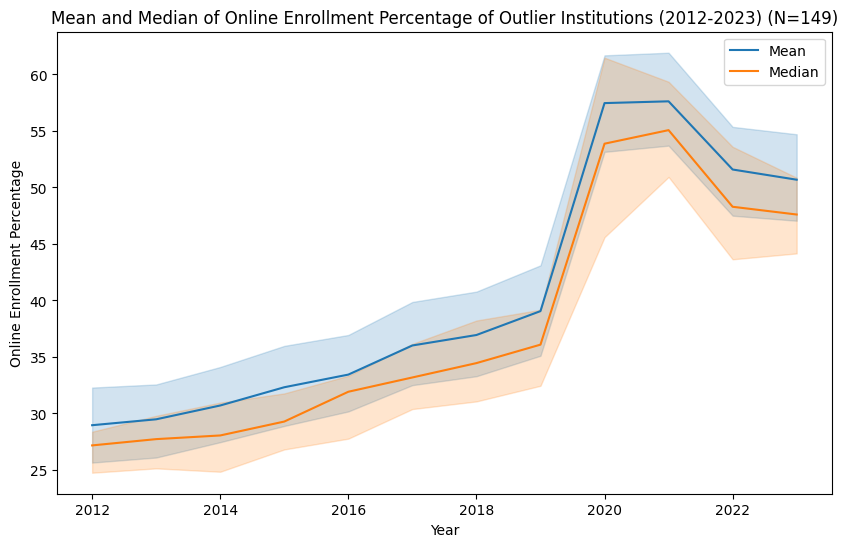

In [ ]:
# viusalize mean and median to see 11-year distribution of erll_dist_perc
plt.figure(figsize=(10,6))
sns.lineplot(x='year', y='erll_dist_perc', data=data_outliers, estimator='mean', label='Mean')
sns.lineplot(x='year', y='erll_dist_perc', data=data_outliers, estimator='median', label='Median')
plt.title('Mean and Median of Online Enrollment Percentage of Outlier Institutions (2012-2023) (N=149)')
plt.xlabel('Year')
plt.ylabel('Online Enrollment Percentage')

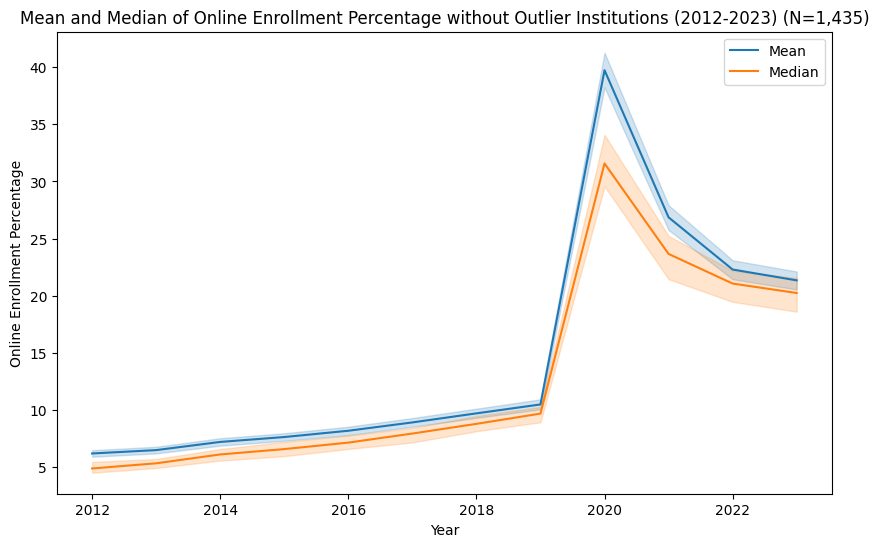

In [60]:
# make a lineplot to see 11-year trend of erll_dist_perc without outliers
plt.figure(figsize=(10,6))
sns.lineplot(x='year', y='erll_dist_perc', data=data_clean, estimator='mean', label='Mean')
sns.lineplot(x='year', y='erll_dist_perc', data=data_clean, estimator='median', label='Median')
plt.title('Mean and Median of Online Enrollment Percentage without Outlier Institutions (2012-2023) (N=1,435)')
plt.xlabel('Year')
plt.ylabel('Online Enrollment Percentage')
plt.show()

In [40]:
# make year the datetime index
data['datetime'] = pd.to_datetime(data['year'], format='%Y')

In [41]:
data['unitid'].nunique() 
# 1584 unique public institutions in the dataset

1584

In [42]:
# only keep datetime, unitid and erll_dist_perc columns
data = data[['datetime', 'unitid', 'erll_dist_perc']]

In [44]:
seed = 0
np.random.seed(seed)

def clustering_euc(df, cl_count):
    # Normalization
    scaler = TimeSeriesScalerMeanVariance(mu=0.0, std=1.0)
    scaled = scaler.fit_transform(to_time_series_dataset(df.values.T))
    # Calculate KMeans
    # try different metrics: "euclidean", "dtw", "softdtw"
    km = TimeSeriesKMeans(n_clusters=cl_count, verbose=True, metric = "euclidean", random_state=seed)
    labels = km.fit_predict(scaled)
    return labels

def clustering_dtw(df, cl_count):
    # Normalization
    scaler = TimeSeriesScalerMeanVariance(mu=0.0, std=1.0)
    scaled = scaler.fit_transform(to_time_series_dataset(df.values.T))
    # Calculate KMeans
    # try different metrics: "euclidean", "dtw", "softdtw"
    km = TimeSeriesKMeans(n_clusters=cl_count, verbose=True, metric = "dtw", random_state=seed)
    labels = km.fit_predict(scaled)
    return labels

def clustering_softdtw(df, cl_count):
    # Normalization
    scaler = TimeSeriesScalerMeanVariance(mu=0.0, std=1.0)
    scaled = scaler.fit_transform(to_time_series_dataset(df.values.T))
    # Calculate KMeans
    # try different metrics: "euclidean", "dtw", "softdtw"
    km = TimeSeriesKMeans(n_clusters=cl_count, verbose=True, metric = "softdtw", random_state=seed)
    labels = km.fit_predict(scaled)
    return labels



# Temporary value
cluster_count = 3

labels_euc_3 = clustering_euc(clst, 3)
labels_euc_4 = clustering_euc(clst, 4)
labels_euc_5 = clustering_euc(clst, 5)
labels_euc_6 = clustering_euc(clst, 6)
labels_euc_7 = clustering_euc(clst, 7)





20.572 --> 16.533 --> 16.419 --> 16.394 --> 16.386 --> 16.382 --> 16.381 --> 16.381 --> 16.380 --> 16.377 --> 16.373 --> 16.369 --> 16.367 --> 16.367 --> 16.367 --> 16.366 --> 16.363 --> 16.361 --> 16.361 --> 16.361 --> 
16.135 --> 13.795 --> 13.680 --> 13.622 --> 13.603 --> 13.586 --> 13.575 --> 13.570 --> 13.568 --> 13.567 --> 13.565 --> 13.564 --> 13.564 --> 13.564 --> 13.564 --> 
15.540 --> 13.288 --> 13.146 --> 13.043 --> 12.932 --> 12.829 --> 12.749 --> 12.688 --> 12.641 --> 12.605 --> 12.581 --> 12.557 --> 12.536 --> 12.519 --> 12.496 --> 12.477 --> 12.457 --> 12.438 --> 12.424 --> 12.413 --> 12.407 --> 12.403 --> 12.397 --> 12.391 --> 12.387 --> 12.384 --> 12.381 --> 12.378 --> 12.373 --> 12.371 --> 12.370 --> 12.369 --> 12.369 --> 12.369 --> 
12.435 --> 10.671 --> 10.536 --> 10.453 --> 10.379 --> 10.303 --> 10.233 --> 10.165 --> 10.083 --> 10.036 --> 10.009 --> 9.989 --> 9.970 --> 9.946 --> 9.919 --> 9.895 --> 9.878 --> 9.861 --> 9.847 --> 9.835 --> 9.827 --> 9.821 --> 9.813 -

In [ ]:
# Get Shops cluster
data.set_index('datetime', inplace=True)
clst = data.pivot(columns='unitid',values='erll_dist_perc').resample('M').sum()

labels_euc = clustering_euc(clst, 3)
labels_dtw = clustering_dtw(clst, 3)
labels_softdtw = clustering_softdtw(clst, 3)

In [46]:
labels_euc

array([1, 0, 1, ..., 2, 2, 2])

In [47]:
# Assign cluster labels to dataframe
clusters = pd.DataFrame({'unitid': clst.columns, 'cluster_euclidean': labels_euc, 'cluster_dtw': labels_dtw, 'cluster_softdtw': labels_softdtw})

In [49]:
clusters.cluster_euclidean.value_counts()

cluster_euclidean
0    678
1    537
2    369
Name: count, dtype: int64

In [50]:
clusters.cluster_dtw.value_counts()

cluster_dtw
0    750
2    548
1    286
Name: count, dtype: int64

In [51]:
clusters.cluster_softdtw.value_counts()

cluster_softdtw
1    774
0    765
2     45
Name: count, dtype: int64

In [61]:
# add it back to original dataframe
data.reset_index(inplace=True)
data = data.merge(clusters, on='unitid', how='left')

In [62]:
data.head()

,datetime,unitid,erll_dist_perc,cluster_euclidean,cluster_dtw,cluster_softdtw
0,2020-01-01,100654,25.225933,1,1,1
1,2022-01-01,100654,4.734411,1,1,1
2,2023-01-01,100654,4.593084,1,1,1
3,2019-01-01,100654,1.574654,1,1,1
4,2021-01-01,100654,4.393880,1,1,1


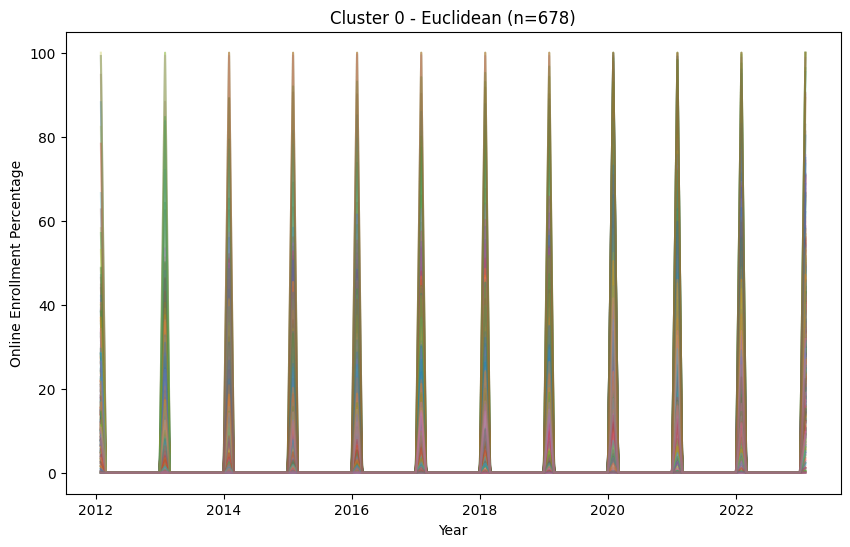

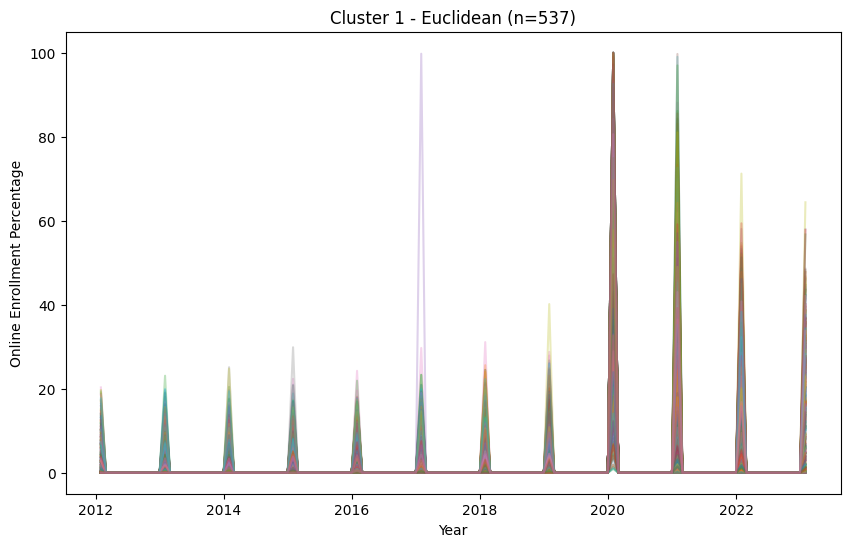

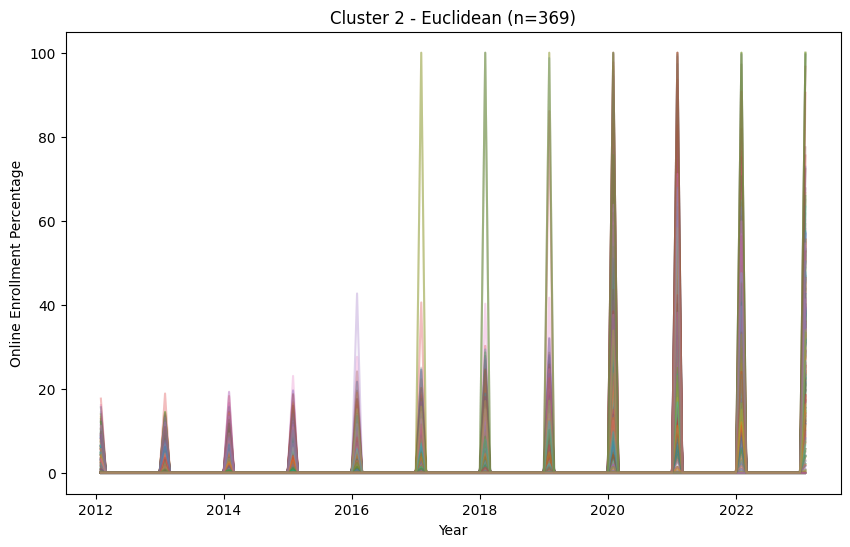

In [64]:
#visualize the clusters
for cluster_num in range(cluster_count):
    cluster_data = clst.loc[:, clusters[clusters['cluster_euclidean'] == cluster_num]['unitid']]
    plt.figure(figsize=(10, 6))
    for col in cluster_data.columns:
        plt.plot(cluster_data.index, cluster_data[col], alpha=0.3)
    plt.title(f'Cluster {cluster_num} - Euclidean (n={cluster_data.shape[1]})')
    plt.xlabel('Year')
    plt.ylabel('Online Enrollment Percentage')
    plt.show()



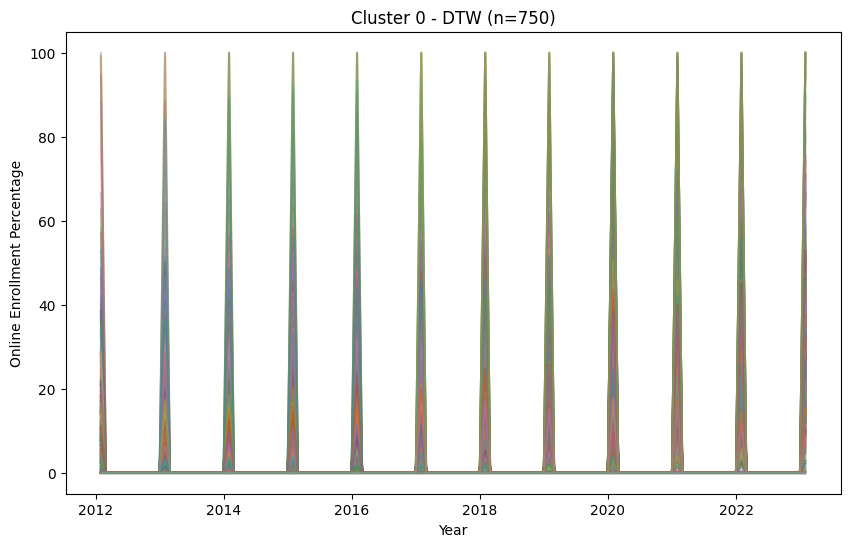

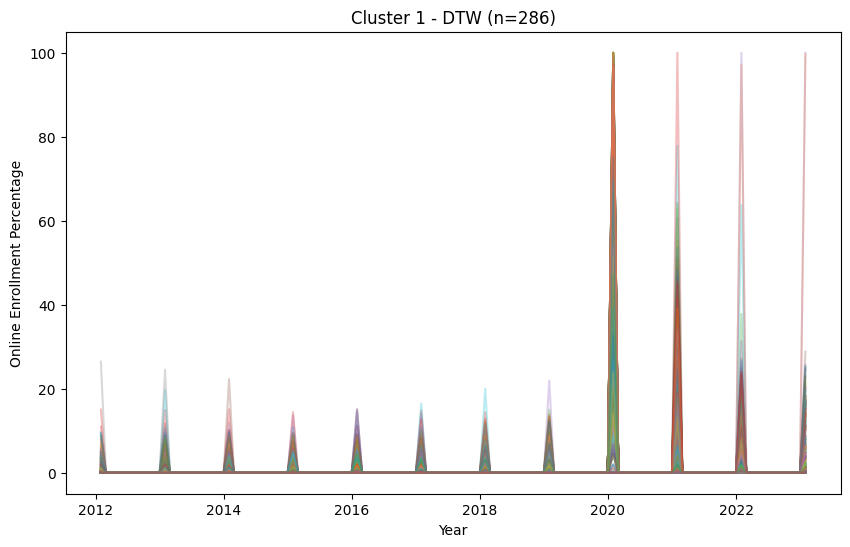

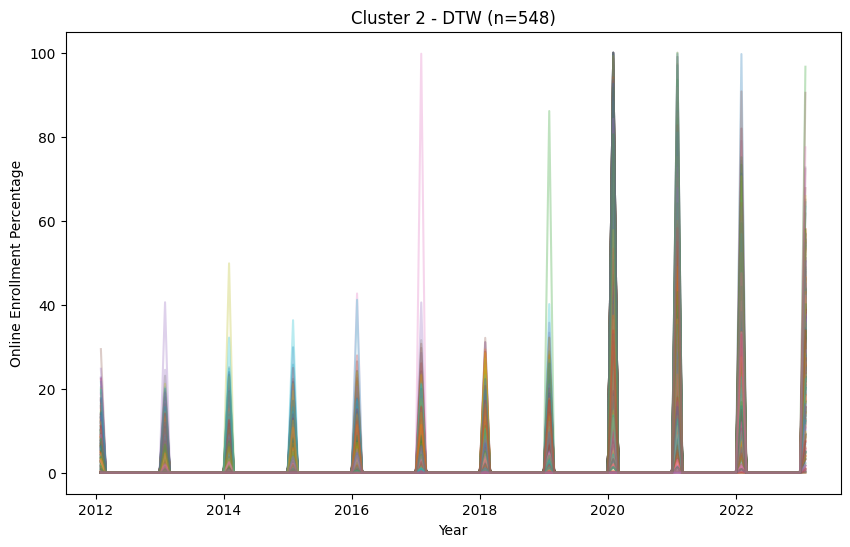

In [ ]:
#visualize the clusters
for cluster_num in range(cluster_count):
    cluster_data = clst.loc[:, clusters[clusters['cluster_dtw'] == cluster_num]['unitid']]
    plt.figure(figsize=(10, 6))
    for col in cluster_data.columns:
        plt.plot(cluster_data.index, cluster_data[col], alpha=0.3)
    plt.title(f'Cluster {cluster_num} - DTW (n={cluster_data.shape[1]})')
    plt.xlabel('Year')
    plt.ylabel('Online Enrollment Percentage')
    plt.show()

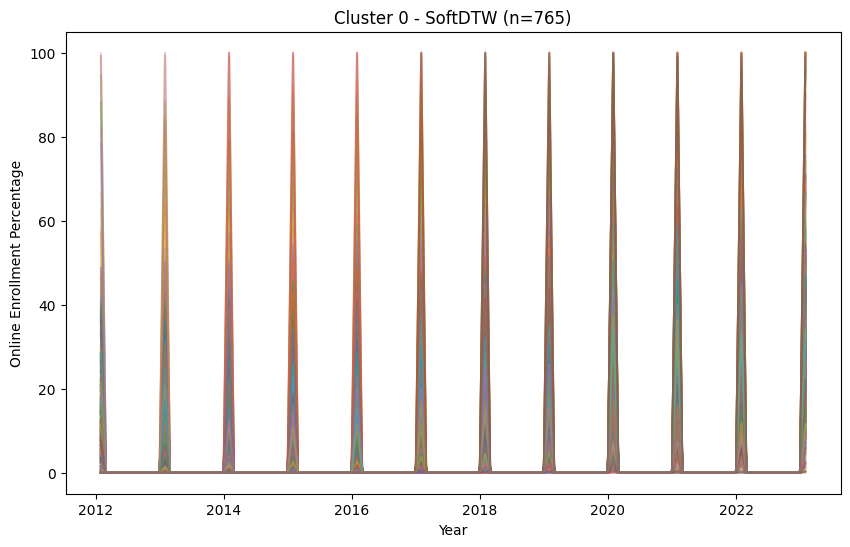

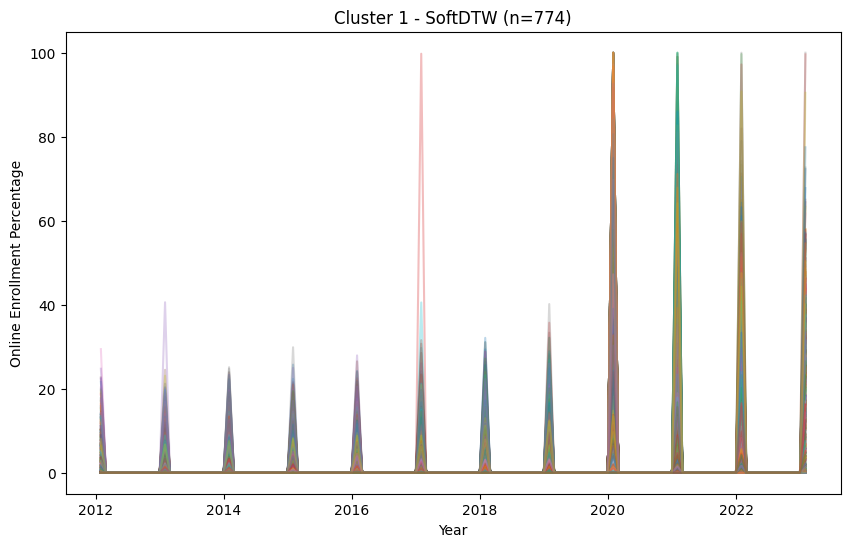

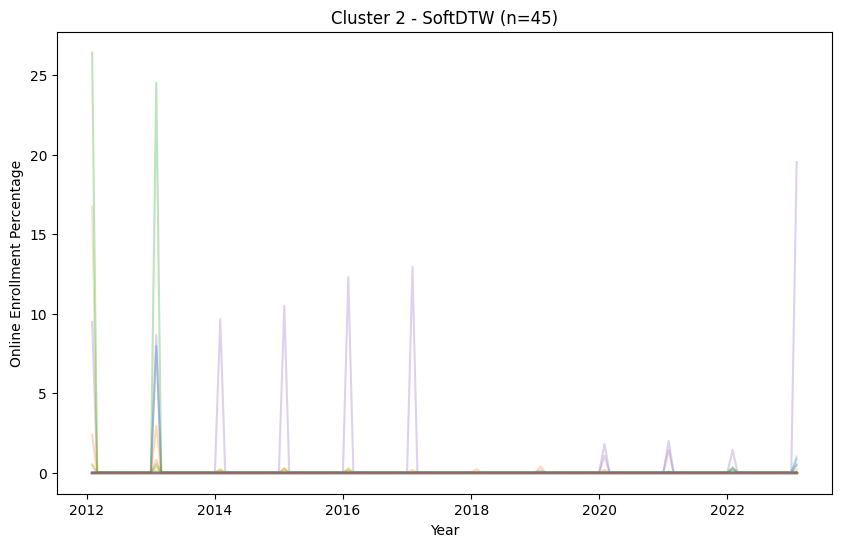

In [66]:
#visualize the clusters
for cluster_num in range(cluster_count):
    cluster_data = clst.loc[:, clusters[clusters['cluster_softdtw'] == cluster_num]['unitid']]
    plt.figure(figsize=(10, 6))
    for col in cluster_data.columns:
        plt.plot(cluster_data.index, cluster_data[col], alpha=0.3)
    plt.title(f'Cluster {cluster_num} - SoftDTW (n={cluster_data.shape[1]})')
    plt.xlabel('Year')
    plt.ylabel('Online Enrollment Percentage')
    plt.show()

In [ ]:
# export the data with clusters
data.to_csv('data_with_inst_clusters1027.csv', index=False)

### Explore different number of clusterings

In [ ]:
# from itertools import product
# from tslearn.preprocessing import TimeSeriesScalerMeanVariance
# from tslearn.utils import to_time_series_dataset
# from tslearn.clustering import TimeSeriesKMeans, silhouette_score

# def clustering(df, cluster_values, metrics=['euclidean', 'dtw', 'softdtw'], seed=0):
#     # Normalize time series data
#     scaler = TimeSeriesScalerMeanVariance(mu=0.0, std=1.0)
#     X = scaler.fit_transform(to_time_series_dataset(df.values.T))

#     best_config = {}
#     best_score = float("-inf")
#     best_model = None

#     # Create parameter grid
#     param_grid = {
#         'n_clusters': cluster_values,
#         'metric': metrics
#     }
#     keys, values = zip(*param_grid.items())
#     param_configs = [dict(zip(keys, v)) for v in product(*values)]

#     # Search through clustering configurations
#     for param in param_configs:
#         model = TimeSeriesKMeans(**param, verbose=True, random_state=seed)
#         labels = model.fit_predict(X)
#         score = silhouette_score(X, labels)

#         if score > best_score:
#             best_score = score
#             best_config = param
#             best_model = model

#     print(f"Best clustering configuration: {best_config}, Silhouette Score: {best_score:.4f}")
#     return best_model, best_config, best_score


In [ ]:
# clustering(clst, cluster_values=range(2, 5))

In [ ]:
# best_model, best_config, best_score = clustering(clst, cluster_values=range(2, 6))

In [ ]:
data.head()

,datetime,unitid,erll_dist_perc,inst_cluster
0,2020-01-01,100654,25.225933,1
1,2022-01-01,100654,4.734411,1
2,2023-01-01,100654,4.593084,1
3,2019-01-01,100654,1.574654,1
4,2021-01-01,100654,4.393880,1


In [ ]:
#make datetime into datetime format
data['datetime'] = pd.to_datetime(data['datetime'], format='%Y-%m-%d')


In [ ]:

data_cluster0 = data[data['inst_cluster'] == 0]
data_cluster1 = data[data['inst_cluster'] == 1]
data_cluster2 = data[data['inst_cluster'] == 2]

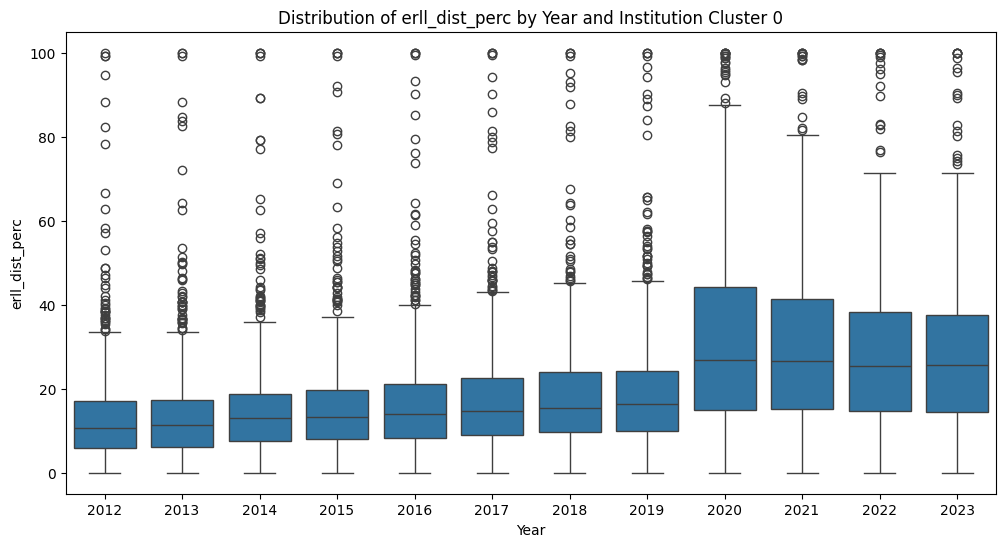

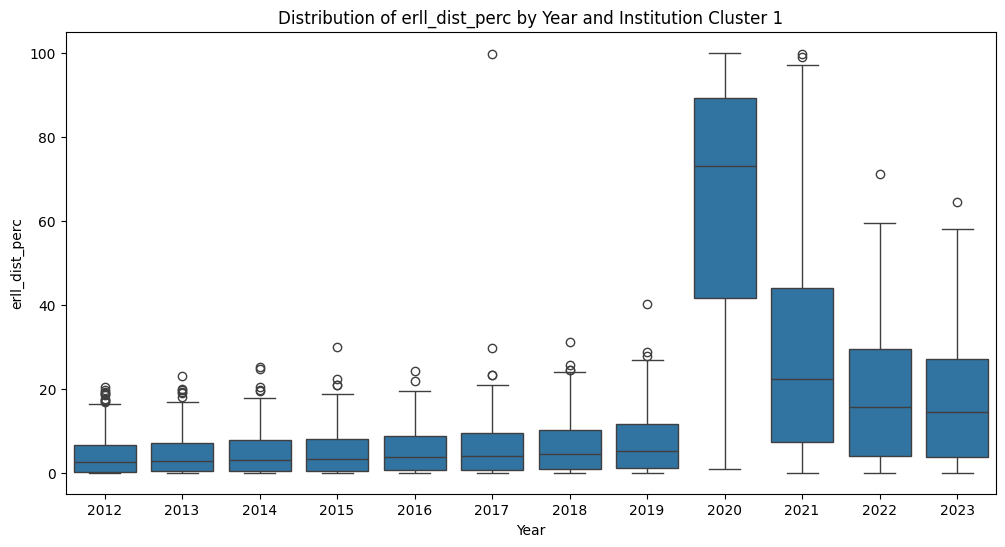

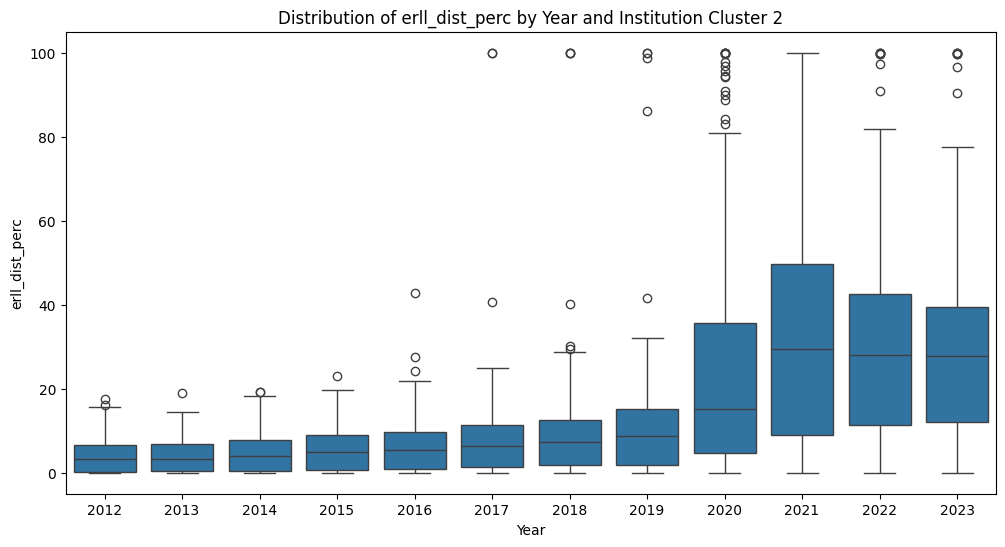

In [ ]:
# show the distribution of erll_dist_perc by year and by inst_cluster and make 4 figures by inst_cluster
# make year from 2012 to 2022
data_cluster0['year'] = data_cluster0['datetime'].dt.year
plt.figure(figsize=(12, 6))
sns.boxplot(x='year', y='erll_dist_perc', data=data_cluster0)
plt.title('Distribution of erll_dist_perc by Year and Institution Cluster 0')
plt.xlabel('Year')
plt.ylabel('erll_dist_perc')
plt.show()

data_cluster1['year'] = data_cluster1['datetime'].dt.year
plt.figure(figsize=(12, 6))
sns.boxplot(x='year', y='erll_dist_perc', data=data_cluster1)
plt.title('Distribution of erll_dist_perc by Year and Institution Cluster 1')
plt.xlabel('Year')
plt.ylabel('erll_dist_perc')
plt.show()

data_cluster2['year'] = data_cluster2['datetime'].dt.year
plt.figure(figsize=(12, 6))
sns.boxplot(x='year', y='erll_dist_perc', data=data_cluster2)
plt.title('Distribution of erll_dist_perc by Year and Institution Cluster 2')
plt.xlabel('Year')
plt.ylabel('erll_dist_perc')
plt.show()



In [ ]:
# Get Shops cluster
data.set_index('datetime', inplace=True)
clst = data.pivot(columns='unitid',values='erll_dist_perc').resample('M').sum()

labels = clustering(clst, 3)

/var/folders/yz/t21562ys7x37ts3_y63c_6fm0000gn/T/ipykernel_33331/1352591564.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  clst = data.pivot(columns='unitid',values='erll_dist_perc').resample('M').sum()


20.572 --> 16.533 --> 16.419 --> 16.394 --> 16.386 --> 16.382 --> 16.381 --> 16.381 --> 16.380 --> 16.377 --> 16.373 --> 16.369 --> 16.367 --> 16.367 --> 16.367 --> 16.366 --> 16.363 --> 16.361 --> 16.361 --> 16.361 --> 


In [ ]:
# Assign cluster labels to dataframe
inst_clusters = pd.DataFrame({'unitid': clst.columns, 'inst_cluster': labels})

In [ ]:
inst_clusters.inst_cluster.value_counts()

inst_cluster
0    678
1    537
2    369
Name: count, dtype: int64

In [ ]:
# make year the datetime index
data = pd.read_csv('initial_analyze1027.csv')
data['datetime'] = pd.to_datetime(data['year'], format='%Y')
data = data[['datetime', 'unitid', 'erll_dist_perc']]
# add it back to original dataframe
data.reset_index(inplace=True)
data = data.merge(inst_clusters, on='unitid', how='left')

/var/folders/yz/t21562ys7x37ts3_y63c_6fm0000gn/T/ipykernel_33331/1095150161.py:2: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('initial_analyze1027.csv')


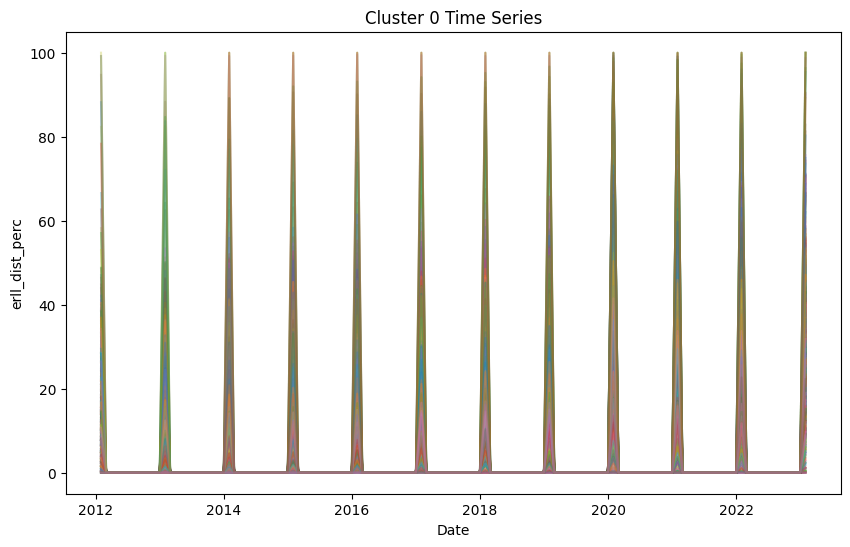

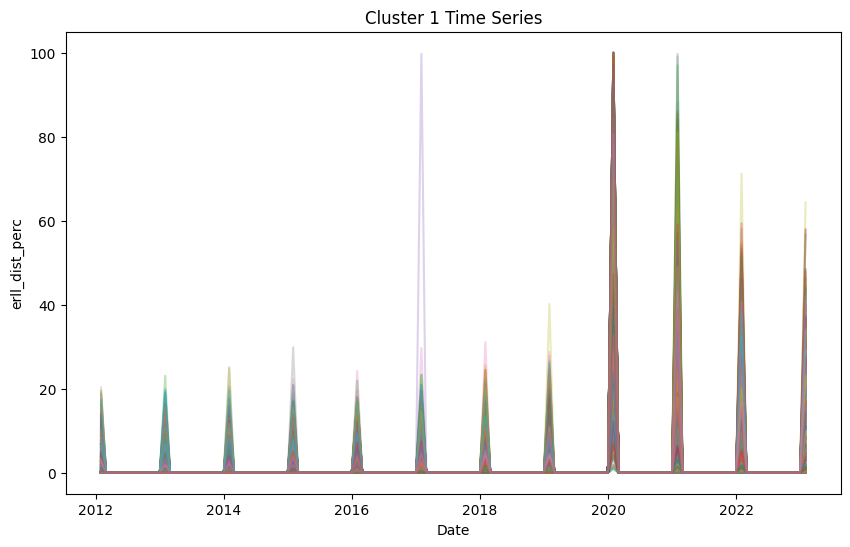

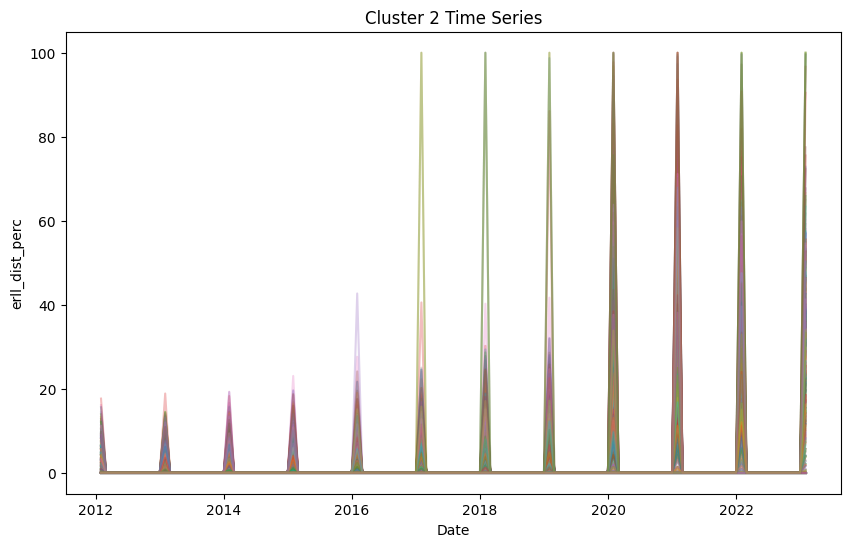

In [ ]:
#visualize the clusters
for cluster_num in range(cluster_count):
    cluster_data = clst.loc[:, inst_clusters[inst_clusters['inst_cluster'] == cluster_num]['unitid']]
    plt.figure(figsize=(10, 6))
    for col in cluster_data.columns:
        plt.plot(cluster_data.index, cluster_data[col], alpha=0.3)
    plt.title(f'Cluster {cluster_num} Time Series')
    plt.xlabel('Date')
    plt.ylabel('erll_dist_perc')
    plt.show()

### explore institutional characteristics of 3 clusters

In [48]:
data = pd.read_csv('data_with_inst_clusters1120.csv')


# keep if inst_cluster is not null
data = data[~data['inst_cluster'].isnull()]
# unique institution count by cluster
data['unitid'].nunique()

1584

In [49]:
# calculate the number of institutions by instsize
data['instsize'].value_counts()



instsize
2    652
3    367
4    266
5    187
1    112
Name: count, dtype: int64

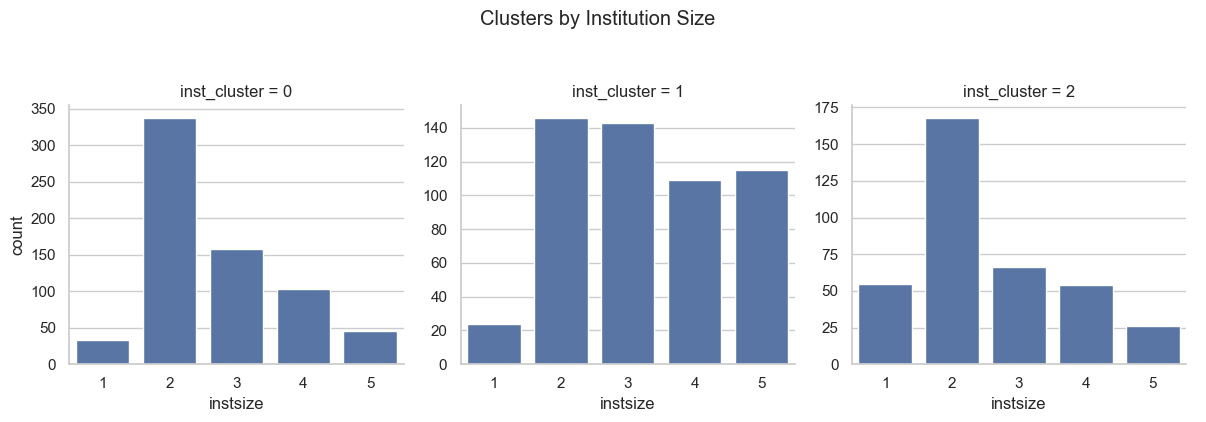

In [32]:
# barplot of inst size by cluster
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")

sns.catplot(
    data=data,
    x="instsize",
    col="inst_cluster",
    kind="count",
    sharey=False,
    height=4,
    aspect=1
)


plt.suptitle("Clusters by Institution Size", y=1.05)
plt.tight_layout()
plt.show()

In [26]:


data['urbanicity'] = data['locale'].apply(lambda x: 'City' if x in [11,12,13] else ('Suburb' if x in [21,22,23] else ('Town' if x in [31,32,33] else ('Rural' if x in [41,42,43] else np.nan))))

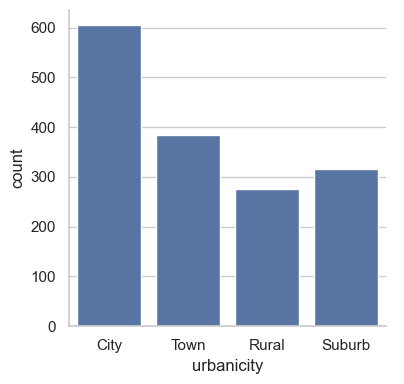

In [27]:
sns.catplot(
    data=data,
    x="urbanicity",
    kind="count",
    sharey=False,
    height=4,
)

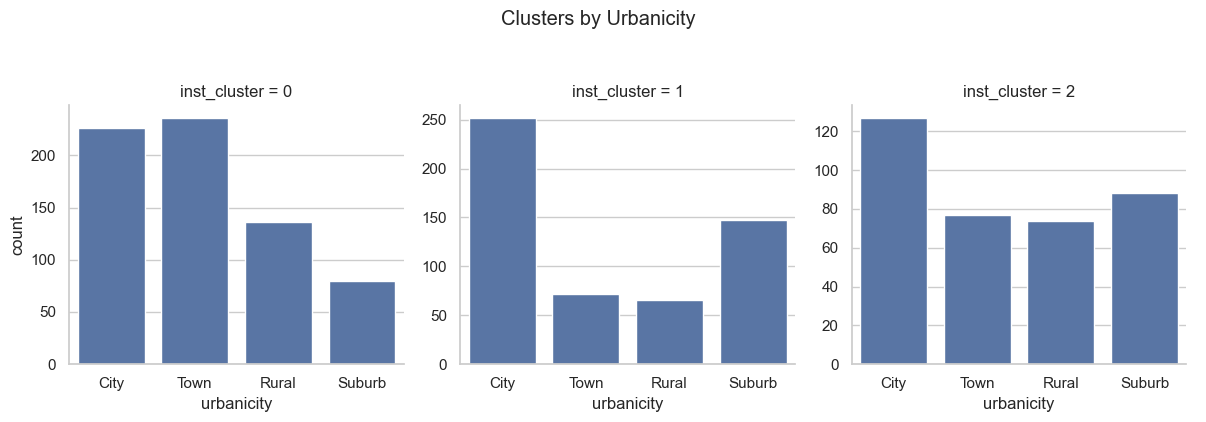

In [33]:
sns.catplot(
    data=data,
    x="urbanicity",
    col="inst_cluster",
    kind="count",
    sharey=False,
    height=4,
    aspect=1
)


plt.suptitle("Clusters by Urbanicity", y=1.05)
plt.tight_layout()
plt.show()

In [29]:
# map carnegie types with c21basic
# c21basic 1-9 correspond to the carnegie 5
# c21basic 10-13 correspond to the carnegie 6
# c21basic 21 and 22 correspond to the carnegie 3
# c21basic 14 and 23 correspond to the carnegie 4
# c21basic 15-17 correspond to the carnegie 1
# c21basic 18-20 correspond to the carnegie 2
# c21basic 24-32 correspond to the carnegie 6
# c21basic 33 correspond to the carnegie 7

# label define label_harmonized 1 "Doctoral/Research Universities" ///
#                             2 "Master's Colleges & Universities" ///
#                             3 "Baccalaureate Colleges" ///
#                             4 "Baccalaureate/Associate's Colleges" ///
#                             5 "Associate's Colleges" ///
#                             6 "Special Focus Institutions" ///
#                             7 "Tribal Colleges" ///
#                             8 "Not applicable"

def map_carnegie(c21basic):
    if c21basic in range(1, 10):
        return 5
    elif c21basic in range(10, 14):
        return 6
    elif c21basic in [21, 22]:
        return 3
    elif c21basic == 14 or c21basic == 23:
        return 4
    elif c21basic in range(15, 18):
        return 1
    elif c21basic in range(18, 21):
        return 2
    elif c21basic in range(24, 33):
        return 6
    elif c21basic == 33:
        return 7
    else:
        return np.nan  
    
data['carnegie21'] = data['c21basic'].apply(map_carnegie)

data['carnegie21'].value_counts()



carnegie21
5.0    829
2.0    236
1.0    230
4.0    130
3.0     83
6.0     34
7.0     29
Name: count, dtype: int64

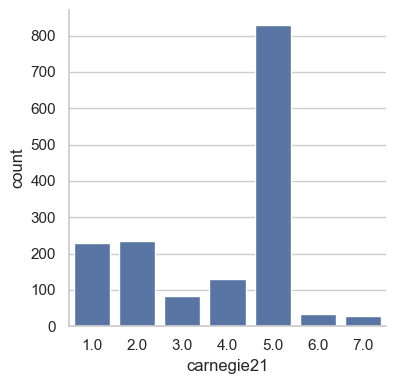

In [30]:
sns.catplot(
    data=data,
    x="carnegie21",
    kind="count",
    sharey=False,
    height=4,
)

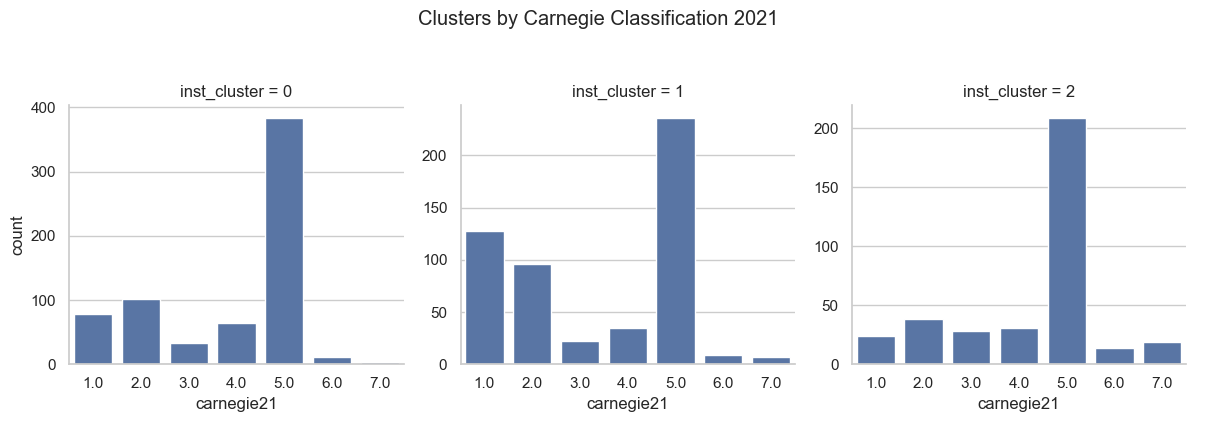

In [34]:
sns.catplot(
    data=data,
    x="carnegie21",
    col="inst_cluster",
    kind="count",
    sharey=False,
    height=4,
    aspect=1
)


plt.suptitle("Clusters by Carnegie Classification 2021", y=1.05)
plt.tight_layout()
plt.show()